# Probabilistic Sharpe Ratio

<i>"Although skewness and kurtosis does not affect the point estimate of Sharpe ratio, it greatly impacts its confidence bands, and consequently its statistical significance”</i> Bailey and López de Prado¹

<b> YouTube Tutorial </b> (Published: Oct 13, 2023): https://youtu.be/aazoO0Db-MI

This tutorial has a [Medium post](https://medium.com/@pythonforquants/is-your-sharpe-ratio-lying-to-you-meet-the-probabilistic-sharpe-ratio-d06077e423e8).


<img src=https://miro.medium.com/v2/resize:fit:450/format:webp/1*RCmv9ucBccu-2ClhOfbjwA.png height=250>

The Sharpe Ratio has long been the go-to metric for evaluating investment performance relative to risk. However, it’s far from perfect and comes with its own set of limitations.

If a strategy has excess returns (risk premium) and returns (r) are independent and identically distributed (IID), where N represents the normal distribution with mean ($\mu$) and variance ($\sigma$).

$r \sim N(\mu, \sigma^2)$

As first introduced by Sharpe, a point estimate of the Sharpe Ratio (SR hat) can be evaluated as⁸:

$\large \hat{SR} = \frac{\hat{\mu}-r_f}{\hat{\sigma}}$



## 1. Limitations of Sharpe Ratio:
1. Point Estimate
2. Assumes Normal Distribution
3. Inadequate for Non-Linear Strategies
4. Penalizes Upside Volatility
5. Sensitive to Time Frame

## 2. Introduction to Probabilistic Sharpe Ratio (PSR)

### Assuming IID Normal Returns

Lo published in The Statistics of Sharpe Ratios assuming independent and identically distributed (IID) Normal returns with skew of 0 and kurtosis of 3, the estimated Sharpe Ratio would follow a normal distribution with standard deviation⁴:

$\large (\hat{SR} - SR) \rightarrow N(0, \frac{1 + \frac{1}{2}SR^2}{n})$

### Assuming non-IID, Non-Normal Returns

Mertens⁵, Christie² and Opdyke⁶ published papers describing the asympototic statistical distribution for the Sharpe Ratio estimate (SR hat). They relaxed the assumptions of normality and independence associated with an unobservable return generating process and only enforced the general assumptions of stationarity (process is time-invariant) and ergodicity (average outcome of a group is the same average outcome for an individual).

$\large (\hat{SR} - SR) \rightarrow N(0, \frac{1 + \frac{1}{2}SR^2 - \gamma_3 SR + \frac{\gamma_4 - 1}{n} SR^2 }{n})$

## Ok, but tell me why this matters?

The mixture of two Gaussians can be used to create a distribution with both skew and kurtosis, allowing for a more realistic modeling of financial returns.

Suppose $r \approx M(\mu_1, \mu_2, \sigma_1, \sigma_2, p)$

What is the $p = f(SR^\star, \mu_1, \mu_2, \sigma_1, \sigma_2)$ so the Mixture of two normal distributions such that:

$SR^\star = \frac{E[r]}{\sqrt{E[r-E[r]]^2}}$

In [ ]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sc
import matplotlib.pyplot as plt

sns.set_theme()
colors=sns.color_palette()
colors+=colors
warnings.filterwarnings( "ignore", module = "seaborn\..*" )

import sys
sys.setrecursionlimit(20000)

Confirm checks and verifications for solving for probability between sampling from two gaussians to calculate exact sharpe ratio as defined in Bailey and Lopez de Prado's paper.

$\large p = \frac{1}{2}\left( -\frac{b}{a} \pm \sqrt{ (\frac{b}{a})^2 - 4 \frac{c}{a} } \right)$

Unique solution if $b^2 \geq 4ac$

Generate mean standard pairs that are within boundary conditions:

for $0 \leq p \leq 1$:

- $\large \frac{\mu_2}{\sigma_2} \geq SR^* \frac{\mu_1}{\sigma_1}$
- $\large \frac{\mu_1}{\sigma_1} \geq SR^* \frac{\mu_2}{\sigma_2}$

In [ ]:
def check_p_unique_soln(a,b,c):
    cond1 = (b**2 >= 4*a*c)
    if cond1:
        return True
    else:
        return False

def check_sign(SR, mu1, mu2, p):
    """Choose correct p value is being choosen for signed SR target
    """
    if np.sign(SR) == np.sign(p*mu1 + (1 - p)*mu2):
        return True
    else:
        return False

def confirm_p_boundaries(SR, mu1, mu2, sigma1, sigma2):
    """Check if p exists within bounds [0,1] with current combination of
    gaussians and Sharpe Ratio (SR) target
    """
    cond1 = (mu2/sigma2 >= SR) &  (SR >= mu1/sigma1)
    cond2 = (mu1/sigma1 >= SR) & (SR >= mu2/sigma2)
    if cond1 or cond2:
        return True
    else:
        return False

In [ ]:
def generate_mean_std_pairs(means=np.empty((1,2)), std_devs=np.empty((1,2)), N=1000):
    """Generate mean, std_dev pairs that create within p_bounds
    for Gaussian Mixture Model
    """
    if len(means) == N:
        return means, std_devs

    mean = np.random.normal(0, 1, (1,2))
    std_dev = sc.stats.halfnorm.rvs(0, 1, (1,2))

    if confirm_p_boundaries(1, mean[0,0], mean[0,1], std_dev[0,0], std_dev[0,1]):
        means = np.concatenate([means, mean])
        std_devs = np.concatenate([std_devs, std_dev])

    return generate_mean_std_pairs(means, std_devs)

In [ ]:
means, std_devs = generate_mean_std_pairs(N=10000)

In [ ]:
def generate_p_along_axis(axis):
    SR, mu1, mu2, sigma1, sigma2 = axis
    a = (1 + 1/(SR**2))*(mu1**2 + mu2**2 - 2*mu1*mu2)
    b = 2*(1 + 1/(SR**2))*(mu1*mu2-mu2**2) - mu1**2 - sigma1**2 + mu2**2 + sigma2**2
    c = mu2**2/(SR**2) - sigma2**2
    log = False
    if check_p_unique_soln(a,b,c):
        p_pos = 0.5*((-b/a) + np.sqrt((b/a)**2 - 4*c/a))
        p_neg = 0.5*((-b/a) - np.sqrt((b/a)**2 - 4*c/a))
        if 1 >= p_pos >= 0:
            if check_sign(SR, mu1, mu2, p_pos):
                return p_pos
        else :
            if check_sign(SR, mu1, mu2, p_neg):
                return p_neg
    else:
        if log:
            print(f'No unique solution for set parameters: \
            \n SR {SR} Mu1 {mu1} Mu2 {mu2} sigma1 {sigma1} sigma2 {sigma2}')

    return np.nan

In [ ]:
along_axis = np.hstack((np.ones(shape=(len(means),1)), means, std_devs))
probs = np.apply_along_axis(generate_p_along_axis, 1, along_axis)
probs[:100]

array([0.36468832,        nan, 0.94079246, 0.21553865, 0.68624061,
       0.90098176,        nan, 0.04936915, 0.0938506 , 0.93582428,
       0.15839675,        nan, 0.99970171, 0.12181191, 0.97831425,
       0.79800359, 0.12046802, 0.00134163, 0.53959307, 0.76569254,
       0.66071234, 0.11507618, 0.9516185 , 0.96880707,        nan,
       0.90875701, 0.7675182 , 0.99969398,        nan, 0.87805672,
       0.66715926, 0.98671156, 0.64187378, 0.10828895, 0.48254841,
       0.58509169, 0.1297067 , 0.18560513, 0.31858059,        nan,
       0.81920294, 0.20066158, 0.61836739, 0.5689203 , 0.63644346,
              nan, 0.54529815, 0.74644455, 0.35748998, 0.99905638,
       0.2061876 ,        nan, 0.50140656, 0.84702444, 0.6834454 ,
       0.94241585, 0.0498956 , 0.48117233, 0.36045443, 0.14904523,
       0.37953793, 0.88001713, 0.82051792, 0.84339367, 0.99415077,
       0.09674395, 0.389592  , 0.93033908, 0.7279526 ,        nan,
       0.90053827,        nan, 0.44124569, 0.31493245,        

In [ ]:
means = means[~np.isnan(probs)]
std_devs = std_devs[~np.isnan(probs)]
probs = probs[~np.isnan(probs)]

In [ ]:
# Function to generate Gaussian Mixture Model data
def generate_gmm_data(means=[0, 0.3], std_devs=[1, 1], weights=[0.5, 0.5], n_samples=50):
    assert len(means) == len(std_devs) == len(weights)
    data = np.array([])
    for i in range(len(means)):
        component = np.random.normal(means[i], std_devs[i], int(n_samples * weights[i]))
        data = np.concatenate((data, component))
    return data

In [ ]:
# Calculate SR standard deviation based on the formula
def calculate_psr_se(sharpe_ratio, skewness, kurtosis, T):
    numerator = 1 - (skewness * sharpe_ratio) + (kurtosis - 1) * (sharpe_ratio ** 2) / 2
    denominator = np.sqrt((1 + sharpe_ratio ** 2) * (T - 1))
    psr_se = np.sqrt(numerator) / denominator
    return psr_se

In [ ]:
returns_ = []
skews = []
kurts = []
standard_errors = []

# Number of data points in each sample
T = 1000

for mean, std_dev, prob in zip(means, std_devs, probs):
    weight = np.array([prob, 1-prob])
    returns = generate_gmm_data(mean, std_dev, weight, T)
    returns_.append(returns)

    # Calculate skewness and kurtosis
    skew = sc.stats.skew(returns)
    kurtosis = sc.stats.kurtosis(returns)
    psr_se = calculate_psr_se(1, skew, kurtosis, T)

    skews.append(skew)
    kurts.append(kurtosis)
    standard_errors.append(psr_se)

<ipython-input-26-95917becf49d>:5: RuntimeWarning: invalid value encountered in sqrt
  psr_se = np.sqrt(numerator) / denominator


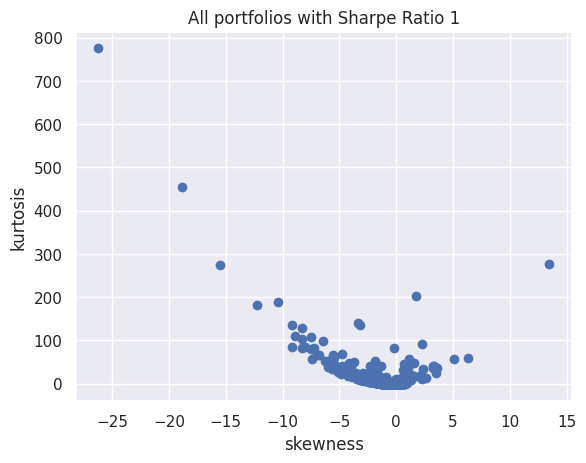

In [ ]:
plt.scatter(skews,kurts)
plt.xlabel('skewness')
plt.ylabel('kurtosis')
plt.title('All portfolios with Sharpe Ratio 1')
plt.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Download data set from plotly repo
fig = go.Figure(data=[go.Mesh3d(x=skews,
                                y=kurts,
                                z=standard_errors,
                                intensity=standard_errors,
                                colorscale='viridis',
                                opacity=1,
                               showscale=True)],
               layout=go.Layout(width=550,
                                height=550,
                               ))

fig.update_scenes(xaxis_title_text='Skewness',
                  yaxis_title_text='Kurtosis',
                  zaxis_title_text='Std Dev of SR')

fig.show()

## 3.0 Sharpe Ratio Confidence Intervals

“Although skewness and kurtosis do not affect the point estimate of the Sharpe ratio, they greatly impact its confidence bands, and consequently its statistical significance”

Ok, so we know skew and kurtosis impact our standard deviation of the Sharpe Ratio, but by how much? Because the distribution around the estimate of the Sharpe Ratio is found to follow the normal distribution with variance as described in the previous section, we arrive at the following estimate standard deviation around our Sharpe Ratio estimate¹.


$\Large \hat{\sigma}_{\hat{SR}} = \sqrt{\frac{1 - \gamma_3 \hat{SR} + (\gamma_4 - 1) \frac{\hat{SR}^2}{4}}{n-1}}$

The estimated standard deviation of the estimate Sharpe ratio (as described in Bailey and López de Prado’s paper). n-1 is Bessel’s correction.

In [ ]:
from scipy.stats import norm

# Estimated Sharpe Ratio (SR) and number of observations (N)
SR_hat = 1
N = 8

# Calculate Standard Deviation of Sharpe Ratio (Std Dev SR)
def standard_deviation_sharpe_ratio(sharpe_ratio, num_obs, skewness=0, kurtosis=3):
    """Estimates standard Deviation of Sharpe Ratio

    Parameters:
    - sharpe_ratio: Sharpe ratio of the strategy
    - bench_sharpe_ratio: Sharpe ratio of the benchmark
    - num_obs: Number of observations
    - skewness: Skewness of the strategy returns (default 0)
    - kurtosis: Kurtosis of the strategy returns (default 3)

    Returns:
    - std_dev: Standard Deviation of Sharpe Ratio
    """
    return np.sqrt(
        (1 - skewness*sharpe_ratio +
         (kurtosis-1)/4*sharpe_ratio**2
        ) / (num_obs-1)
    )

# Portfolio Returns with Normality
sigma_hat_normal_returns = standard_deviation_sharpe_ratio(sharpe_ratio=SR_hat,
                                                           num_obs=N,
                                                           skewness=0,
                                                           kurtosis=3)

# Portfolio Returns with Non-Normality
sigma_hat_higher_moments = standard_deviation_sharpe_ratio(sharpe_ratio=SR_hat,
                                                           num_obs=N,
                                                           skewness=-3.5,
                                                           kurtosis=10)

def two_sided_confidence_intervals(sharpe_ratio, standard_deviation, confidence_level):
    """Sharpe Ratio two-sided confidence intervals

    Parameters:
    - sharpe_ratio: Sharpe ratio of the strategy
    - standard_devation: Standard Deviation of Sharpe Ratio
    - confidence_level: level of confidence (fraction: i.e. 0.90 for 90%)

    Returns:
    - lower_bound: two-sided lower bound
    - upper_bound: two-sided upper bound
    """
    # Two-sided (1-alpha)% Confidence Interval
    alpha = 1 - confidence_level
    Z_alpha_over_2 = sc.stats.norm.ppf(1-alpha/2)  # 95% CI

    lower_bound = sharpe_ratio - Z_alpha_over_2 * standard_deviation
    upper_bound= sharpe_ratio + Z_alpha_over_2 * standard_deviation

    return lower_bound, upper_bound

lower_norm, upper_norm = two_sided_confidence_intervals(SR_hat,
                                                  sigma_hat_normal_returns,
                                                  0.95)

lower_non_norm, upper_non_norm = two_sided_confidence_intervals(SR_hat,
                                                  sigma_hat_higher_moments,
                                                  0.95)

# Print the confidence intervals
print(f"Normally Distributed; Two-sided 95% CI:     [{lower_norm:2.4f}, {upper_norm:2.4f}]")
print(f"Non-Normally Distributed; Two-sided 95% CI: [{lower_non_norm:2.4f}, {upper_non_norm:2.4f}]")

Normally Distributed; Two-sided 95% CI:     [0.0927, 1.9073]
Non-Normally Distributed; Two-sided 95% CI: [-0.9246, 2.9246]


The higher and lower confidence levels of the non-normally distributed portfolio highlights how skewness and kurtosis with limited number of observations could cause significant inflation of the simple point estimate of the Sharpe Ratio.

### Plotting impact of Confidence Intervals as Data Increases

In [ ]:
norm_vals = np.array([[],[]])
non_norm_vals = np.array([[],[]])
N = np.arange(1,51,1)

for n in N:
    # Portfolio Returns with Normality
    sigma_hat_normal_returns = standard_deviation_sharpe_ratio(sharpe_ratio=SR_hat,
                                                               num_obs=n,
                                                               skewness=0,
                                                               kurtosis=3)

    # Portfolio Returns with Non-Normality
    sigma_hat_higher_moments = standard_deviation_sharpe_ratio(sharpe_ratio=SR_hat,
                                                               num_obs=n,
                                                               skewness=-3.5,
                                                               kurtosis=10)

    lower_norm, upper_norm = two_sided_confidence_intervals(SR_hat,
                                                  sigma_hat_normal_returns,
                                                  0.95)

    lower_non_norm, upper_non_norm = two_sided_confidence_intervals(SR_hat,
                                                      sigma_hat_higher_moments,
                                                      0.95)

    norm_vals_arr = np.array([[lower_norm, upper_norm]])
    non_norm_vals_arr = np.array([[lower_non_norm, upper_non_norm]])

    if norm_vals.size != 0:
        norm_vals = np.concatenate((norm_vals, norm_vals_arr))
        non_norm_vals = np.concatenate((non_norm_vals, non_norm_vals_arr))
    else:
        norm_vals = norm_vals_arr
        non_norm_vals = non_norm_vals_arr

<ipython-input-30-916ced02ce57>:22: RuntimeWarning:

divide by zero encountered in divide



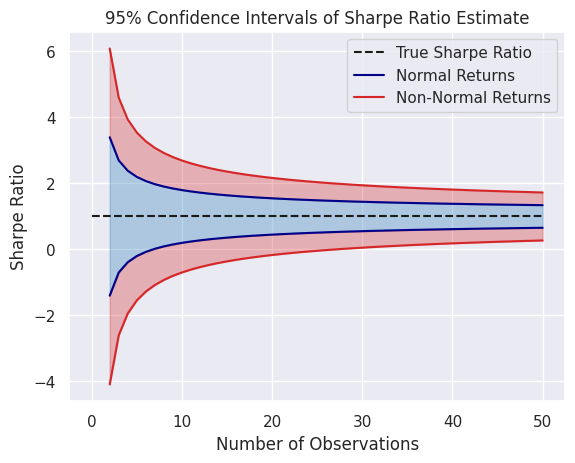

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot([0,50],[1,1], 'k--')
ax.plot(N,norm_vals[:,0], color='darkblue')
ax.plot(N,non_norm_vals, color='tab:red')
ax.plot(N,norm_vals[:,1], color='darkblue')

ax.fill_between(N, norm_vals[:,1], non_norm_vals[:,1],color='tab:red', alpha=0.3)
ax.fill_between(N, norm_vals[:,0], norm_vals[:,1],color='tab:blue', alpha=0.3)
ax.fill_between(N, norm_vals[:,0], non_norm_vals[:,0],color='tab:red', alpha=0.3)


plt.xlabel('Number of Observations')
plt.ylabel('Sharpe Ratio')
plt.title('95% Confidence Intervals of Sharpe Ratio Estimate')

plt.legend(['True Sharpe Ratio','Normal Returns','Non-Normal Returns'])

plt.show()

As we can see from the graph, the number of observed returns and the statistical properties of the underlying returns distribution greatly impact the confidence intervals around the Sharpe Ratio estimate.

The main conclusion we would like to draw here, is that Sharpe Ratio estimates are great impacted by these statistical traits:

- <b>Non-normality</b>: skewness and kurtosis
- <b>Reduced granularity</b>: due to returns aggregation
  
For the risk adverse investor, this example illustrates the importance of considering skewness and kurtosis when using the sharpe ratio for portfolio selection.



## 4.0 Mathematical Derivation of Probabilistic Sharpe Ratio (PSR)

To fully appreciate the power of the Probabilistic Sharpe Ratio (PSR), let’s delve into its mathematical underpinnings. Recall the formula, as developed by Bailey and López de Prado¹:


$\large \hat{PSR}(SR^*) = Prob[SR \leq \hat{SR}] = \int_{-\infty}^{\hat{SR}} \varphi(SR|SR^*, \hat{\sigma}_{\hat{SR}}) dSR$

<i>where</i>:

$\varphi(SR|SR^*, \hat{\sigma}_{\hat{SR}})$ is the <i>pdf</i> of the Normal Distribution with mean of $SR^*$ and standard deviation of $\hat{\sigma}_{\hat{SR}}$

$\Large \hat{PSR}(SR^*) = \Phi \left( \frac{(\hat{SR} - SR^*)\sqrt{n-1}}{\sqrt{1 - \hat{\gamma_3}\hat{SR} + \frac{\hat{\gamma_4} - 1}{4} \hat{SR}^2}} \right)$

where $\Phi$ is the cumulative distribution function of a standard normal distribution, $SR$ is the Sharpe Ratio, $SR^*$ is the benchmark Sharpe Ratio, $n$ is the number of observations, and skewness ($\gamma_3$) and kurtosis ($\gamma_4$) are the third and fourth standardized moments, respectively.

In [ ]:
def probabilistic_sharpe_ratio(sharpe_ratio, bench_sharpe_ratio, num_obs, skewness, kurtosis):
    """
    Calculates the Probabilistic Sharpe Ratio

    Parameters:
    - sharpe_ratio: Sharpe ratio of the strategy
    - bench_sharpe_ratio: Sharpe ratio of the benchmark
    - num_obs: Number of observations
    - skewness: Skewness of the strategy returns
    - kurtosis: Kurtosis of the strategy returns

    Returns:
    - psr: Probabilistic Sharpe Ratio
    """

    sr_diff = sharpe_ratio - bench_sharpe_ratio
    sr_vol = standard_deviation_sharpe_ratio(sharpe_ratio, num_obs, skewness, kurtosis)
    psr = sc.stats.norm.cdf(sr_diff / sr_vol)

    return psr

In [ ]:
# Sample data
SR = 0.5  # Your strategy's Sharpe Ratio
Bench_SR = 0.3  # Benchmark Sharpe Ratio
skewness = -0.2  # Skewness of your strategy
kurtosis = 3.5  # Kurtosis of your strategy
N = 252  # Number of observations (trading days in a year, for example)

# Calculate PSR
PSR_value = probabilistic_sharpe_ratio(SR, Bench_SR, N, skewness, kurtosis)
print(f"Probabilistic Sharpe Ratio: {PSR_value}")

Probabilistic Sharpe Ratio: 0.9976508273723758


## 5.0 A Tricky but Realistic Example…

In the graph below there are two portfolio’s with exactly the same True Sharpe Ratio of 1.5:

1. Returns are normally distributed (iid)
2. Returns are non-normally distributed (iid) with skew of ~ -1.2 and kurtosis of ~5.3

The mixture of two Gaussians can be used to create a distribution with both skew and kurtosis, allowing for a more realistic modeling of financial returns. Below in the chart, gmm (blue distribution), is a gaussian mixture model between two normal distributions with roughly 8% chance of sampling from gaussian 2 and 92% from gaussian 1. The resulting returns distribution has significant non-normal statistical traits, however, it has the exact same Sharpe Ratio of 1.5 as in the normally distributed portfolio in red.

In [ ]:
# Function to generate Gaussian Mixture Model data
def generate_gmm_data_separated(means=[0, 0.3], std_devs=[1, 1], weights=[0.5, 0.5], n_samples=50):
    assert len(means) == len(std_devs) == len(weights)
    data1, data2 = np.array([]), np.array([])
    component1 = np.random.normal(means[0], std_devs[0], int(n_samples * weights[0]))
    component2 = np.random.normal(means[1], std_devs[1], int(n_samples * weights[1]))
    data1 = np.concatenate((data1, component1))
    data2 = np.concatenate((data2, component2))
    return data1, data2

Probability for GMM is 0.9203643675718296


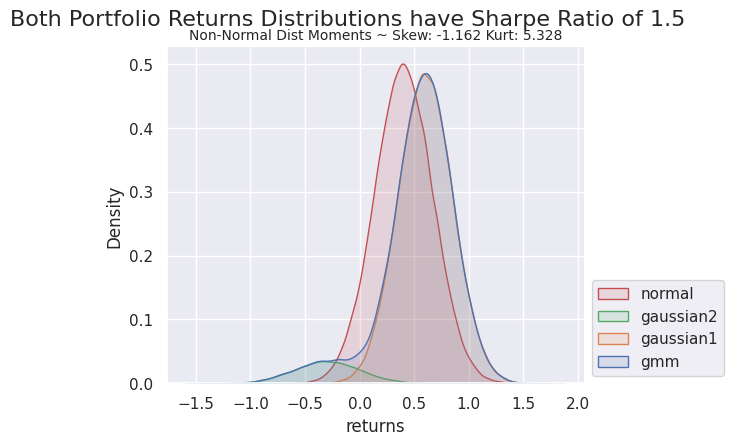

In [ ]:
means=np.array([0.6, -0.3])
std_devs=np.array([0.25, 0.3])
SR = np.array([1.5])
along_axis = np.hstack((SR, means, std_devs))
probs = generate_p_along_axis(along_axis)
print(f"Probability for GMM is {probs}")

data1, data2 = generate_gmm_data_separated(means, std_devs, weights=[probs, 1-probs], n_samples=100000)
gmm = generate_gmm_data(means, std_devs, weights=[probs, 1-probs], n_samples=100000)

skew, kurt = sc.stats.skew(gmm), sc.stats.kurtosis(gmm)
mean=0.4
normal = np.random.normal(loc=mean, scale=mean/1.5, size=100000)

sns.displot([gmm, data1, data2, normal], kind='kde', fill=True, legend=False, alpha=0.15, height=4, aspect=1.3)
plt.legend(['normal','gaussian2', 'gaussian1', 'gmm'], loc='lower left', bbox_to_anchor=(1, 0))
plt.xlabel('returns')
plt.suptitle('Both Portfolio Returns Distributions have Sharpe Ratio of 1.5', y=1.05, fontsize=16)
plt.title(f'Non-Normal Dist Moments ~ Skew: {skew:2.3f} Kurt: {kurt+3:2.3f}', fontsize=10)
plt.show()

Although both portfolio’s have exactly the same Sharpe Ratio, depending on the number of returns observations we would have very different confidence levels around our estimates.

Let’s say we are considering both portfolio’s and only have 2 years of quarterly returns to estimate the Sharpe Ratio’s. This would be a total of 8 data points. The following code allows us to simulate the portfolio’s from their respective true distributions and visualise the results. The graphs below show estimated:

- Sharpe Ratios,
- Probabilistic Sharpe Ratio,
- Confidence Intervals, and
- Higher Order Moments (skew and kurtosis).

Probability for GMM is 0.9203643675718296


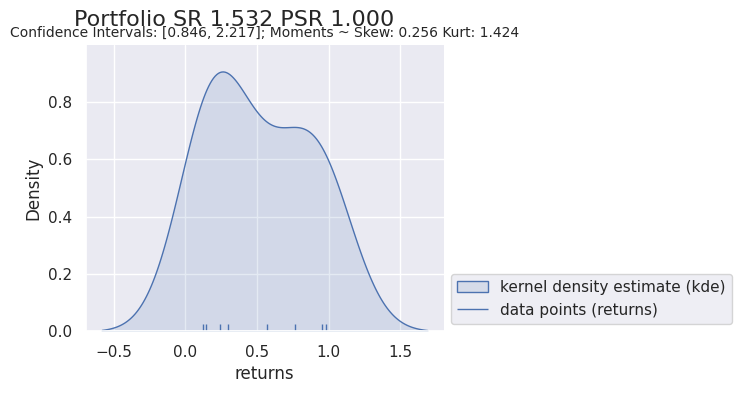

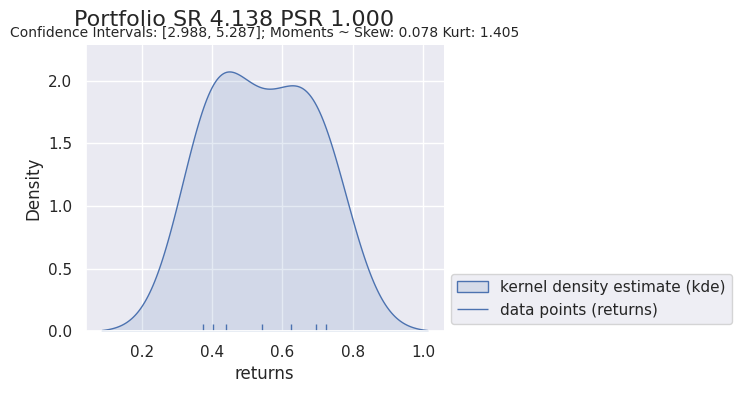

In [ ]:
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt

benchmark_sr=0
no_obs=8
means=np.array([0.6, -0.3])
std_devs=np.array([0.25, 0.3])
SR = np.array([1.5])
along_axis = np.hstack((SR, means, std_devs))
probs = generate_p_along_axis(along_axis)

print(f"Probability for GMM is {probs}")

mean=0.4
normal = np.random.normal(loc=mean, scale=mean/1.5, size=no_obs)
gmm1 = generate_gmm_data(means, std_devs, weights=[probs, 1-probs], n_samples=no_obs)

sharpe_ratio0 = np.mean(normal)/np.std(normal)
skew0 = sc.stats.skew(normal)
kurt0 = sc.stats.kurtosis(normal)
psr0 = probabilistic_sharpe_ratio(sharpe_ratio0, benchmark_sr, no_obs, skew0, kurt0+3)
sigma0 = standard_deviation_sharpe_ratio(sharpe_ratio0, no_obs, skew0, kurt0+3)
confinv0 = two_sided_confidence_intervals(sharpe_ratio0, sigma0, 0.95)

sharpe_ratio1 = np.mean(gmm1)/np.std(gmm1)
skew1 = sc.stats.skew(gmm1)
kurt1 = sc.stats.kurtosis(gmm1)
psr1 = probabilistic_sharpe_ratio(sharpe_ratio1, benchmark_sr, no_obs, skew1, kurt1+3)
sigma1 = standard_deviation_sharpe_ratio(sharpe_ratio1, no_obs, skew1, kurt1+3)
confinv1 = two_sided_confidence_intervals(sharpe_ratio1, sigma1, 0.95)

def displot(data, sharpe_ratio, psr, skew, kurtosis, confinv):
    sns.displot([data], kind='kde', fill=True, rug=True, legend=False, alpha=0.15, height=3.5, aspect=1.3)
    plt.legend(['kernel density estimate (kde)','data points (returns)'], loc='lower left', bbox_to_anchor=(1, 0))
    plt.xlabel('returns')
    plt.suptitle(f'Portfolio SR {sharpe_ratio:2.3f} PSR {psr:2.3f}', y=1.05, fontsize=16)
    plt.title(f'Confidence Intervals: [{confinv[0]:2.3f}, {confinv[1]:2.3f}]; Moments ~ Skew: {skew:2.3f} Kurt: {kurtosis+3:2.3f}', fontsize=10)
    plt.show()

displot(normal, sharpe_ratio0, psr0, skew0, kurt0, confinv0)
displot(gmm1, sharpe_ratio1, psr1, skew1, kurt1, confinv1)

This observation natural leads us to think:

<i>“How long should a track record be in order to have statistical confidence that its Sharpe ratio is above a given threshold?” Bailey and López de Prado¹ </i>

This is a question we will address in our next article.

## 6.0 Summary

In this article, we’ve delved into the nuances of Probabilistic Sharpe Ratio (PSR), offering a more comprehensive lens for evaluating portfolio performance. Building upon the original work by Lo⁴, Mertens⁵, Christie² and Opdyke⁶ both Bailey and López de Prado’s created a metric that accounts for the standard deviation and uncertainty associated with estimating Sharpe Ratio even from portfolio’s with true distributions that are non-normally distributed.

Sharpe Ratios are greatly impacting by statistical traits like non-normality and reduced granularity, and therefore Bailey and Lopez de Prado recommend adopting:

- <b>Probabilistic Sharpe Ratio (PSR)</b>: By incorperating the PSR metric into our analysis we are accounting for the non-normal characteristics that can impact statistical significance our Sharpe Ratio estimate. Therefore by using the PSR we can reduce the rate of discovery of false positives (Type I errors).
- <b>High-Frequency Reporting</b>: For portfolios with undesirable statistical traits, the paper advocates for the highest reporting frequency that doesn’t violate the IID (Independently and Identically Distributed) assumption, enhancing the reliability of the performance metrics.
  
Bailey and López de Prado also created a frameword to determine the minimum track record length required to have statistical confidence that a Sharpe Ratio is above a given threshold. This is be the topic of discussion in the next article!

## References
1. Bailey DH, López de Prado, M. The Sharpe Ratio Efficient Frontier. Journal of Risk. 2012; 15(2). doi: 10.2139/ssrn.1821643
2. Christie S. Is the Sharpe Ratio Useful in Asset Allocation. AFC Research Papers №31, Applied Finance Centre, Macquarie University. 2005. doi: 10.2139/ssrn.720801
3. Hogg R, Tanis E. Probability and Statistical Inference. Pearson. 9th ed. 2013.
4. Lo A. The Statistics of Sharpe Ratios. Financial Analysts Journal. 2002; 58(4): 36–52. doi: 10.2469/faj.v58.n4.2453
5. Mertens E. Variance of the IID estimator in Lo (2002). Working paper, University of Basel. 2002.
6. Opdyke J. Comparing Sharpe ratios: so where are the p-values?. Journal of Asset Management. 2007; 8(5): 308–336. doi: 10.1057/palgrave.jam.2250084
7. Rollinger TN, Hoffman ST. Sortino: A ‘Sharper’ Ratio. Red Rock. 2016. http://www.redrockcapital.com/Sortino__A__Sharper__Ratio_Red_Rock_Capital.pdf
8. Sharpe W. The Sharpe ratio. Journal of Portfolio Management. 1994; 21(1): 49–58. doi: 10.3905/jpm.1994.409501